# 📝 Insult Detection with Word2Vec Embeddings

In this notebook, we will build a binary classification pipeline to detect insults in comments using Word2Vec embeddings. We'll apply:
- Logistic Regression
- Random Forest
- XGBoost

## 🚀 Goal
Detect whether a comment contains an insult (1) or not (0).


## 📦 Step 1: Install & Load Packages

In [4]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
!pip install kagglehub

In [2]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix



In [7]:
import gensim

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import kagglehub


## 📥 Step 2: Load and Inspect the Dataset


In [3]:
# Dataset: Jigsaw Toxic Comment Classification (we'll use the insult label) from kaggle


# Download latest version
path = kagglehub.dataset_download("julian3833/jigsaw-toxic-comment-classification-challenge")

print("Path to dataset files:", path)

100%|██████████| 53.4M/53.4M [00:00<00:00, 158MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/julian3833/jigsaw-toxic-comment-classification-challenge/versions/1


In [4]:
df  = pd.read_csv(path + "/train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df = df[["comment_text", "insult"]]
df.head()

,comment_text,insult
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df['insult'].value_counts()

,count
insult,
0,151694
1,7877


## 🧹 Step 3: Preprocessing for Word2Vec



In [8]:
# We'll use Gensim's `simple_preprocess` to tokenize and clean the text.
def preprocess(text):
    return [word for word in simple_preprocess(text) if word not in STOPWORDS]


df['cleaned_text'] = df['comment_text'].apply(preprocess)
df.head()


,comment_text,insult,cleaned_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, username, hardcore, metal..."
1,D'aww! He matches this background colour I'm s...,0,"[aww, matches, background, colour, seemingly, ..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, trying, edit, war, guy, constantly,..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[real, suggestions, improvement, wondered, sec..."
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page]"


## 🧠 Step 4: Train Word2Vec Embedding

In [9]:
# We'll train Word2Vec embeddings on the entire corpus.

model = Word2Vec(
    sentences=df['cleaned_text'],
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1
)

In [10]:
model.wv.most_similar("explanation")

[('reintroduce', 0.732398509979248),
 ('satisfactory', 0.728868305683136),
 ('lacking', 0.7281979322433472),
 ('woefully', 0.7181955575942993),
 ('justification', 0.7123537659645081),
 ('oddity', 0.7121139168739319),
 ('preventented', 0.7082703113555908),
 ('hapgood', 0.7061578631401062),
 ('gustafson', 0.7056165337562561),
 ('cryptic', 0.7054038643836975)]

## 🧬 Step 5: Vectorize Comments using Word2Vec


In [11]:
# Convert each comment to the average of its word vectors

def comment_to_vector(comment, model, vector_size):
    vector = np.zeros(vector_size)
    num_words = 0
    for word in comment:
        if word in model.wv:
            vector += model.wv[word]
            num_words += 1
    if num_words > 0:
        vector /= num_words
    return vector



In [14]:
# Convert to final feature and label arrays


vector_size = 100
X = np.array([comment_to_vector(comment, model, vector_size) for comment in df['cleaned_text']])


y = np.array(df['insult'])

In [15]:
# Train/Test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🤖 Step 6: Train Models

In [16]:
def evaluate_model(model, name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔍 {name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



🔍 Logistic Regression Accuracy: 0.9642
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     30301
           1       0.74      0.44      0.56      1614

    accuracy                           0.96     31915
   macro avg       0.86      0.72      0.77     31915
weighted avg       0.96      0.96      0.96     31915



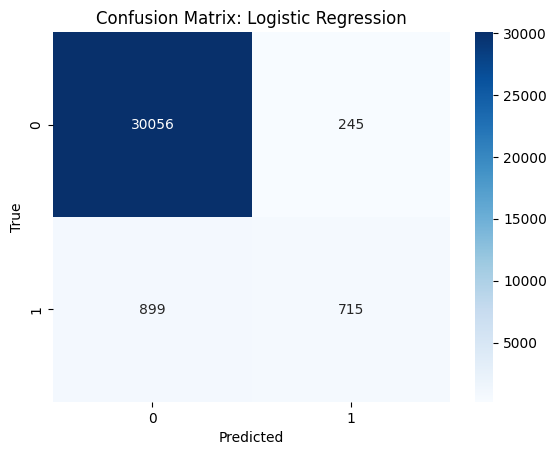

In [17]:
# Logistic Regression
lr_model = LogisticRegression()
evaluate_model(lr_model, "Logistic Regression")


🔍 Random Forest Accuracy: 0.9667
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     30301
           1       0.82      0.44      0.57      1614

    accuracy                           0.97     31915
   macro avg       0.90      0.72      0.78     31915
weighted avg       0.96      0.97      0.96     31915



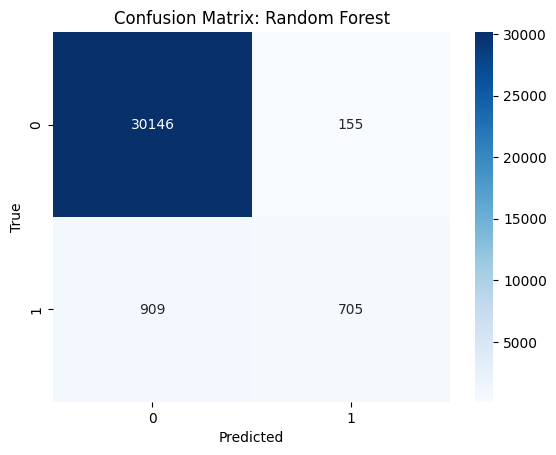

In [18]:
# Random Forest
random_forest_model = RandomForestClassifier()
evaluate_model(random_forest_model, "Random Forest")


🔍 XGBoost Accuracy: 0.9686
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     30301
           1       0.75      0.57      0.65      1614

    accuracy                           0.97     31915
   macro avg       0.86      0.78      0.81     31915
weighted avg       0.97      0.97      0.97     31915



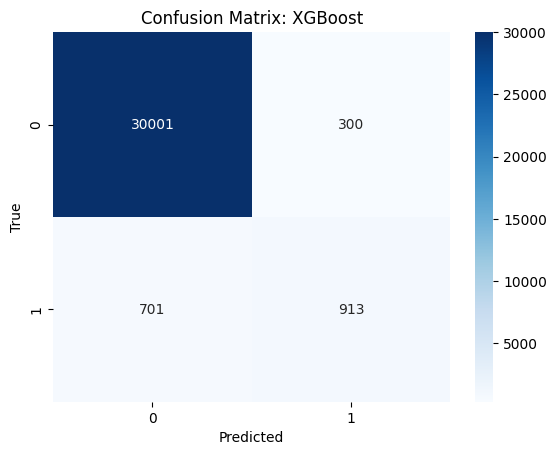

In [19]:
# XGBoost
xgboost = XGBClassifier()
evaluate_model(xgboost, "XGBoost")


## 📌 Summary

- You learned how to use Word2Vec embeddings for **insult detection**
- Built a custom vectorizer by averaging word vectors
- Trained Logistic Regression, Random Forest, and XGBoost on the resulting features

### 🔍 Next Steps
- Try pre-trained Word2Vec (e.g. Google News vectors)
- Use TF-IDF weighting for word embeddings
- Try deep learning models (LSTM, BERT, etc.)

🎉 Great job on completing this project!